# REINFORCE in TensorFlow (3 pts)¶

This notebook implements a basic reinforce algorithm a.k.a. policy gradient for CartPole env.

It has been deliberately written to be as simple and human-readable.

Authors: [Practical_RL](https://github.com/yandexdataschool/Practical_RL) course team

The notebook assumes that you have [openai gym](https://github.com/openai/gym) installed.

In case you're running on a server, [use xvfb](https://github.com/openai/gym#rendering-on-a-server)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


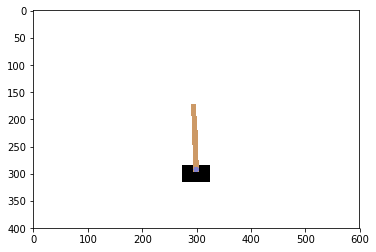

In [1]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

#gym compatibility: unwrap TimeLimit
if hasattr(env,'env'):
    env=env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

In [2]:
import tensorflow as tf

#create input variables. We only need <s,a,R> for REINFORCE
states = tf.placeholder('float32',(None,)+state_dim,name="states")
actions = tf.placeholder('int32',name="action_ids")
cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")

/home/apodolskiy/anaconda3/envs/Edward/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tensorflow.contrib.layers import fully_connected

Instructions for updating:
Use the retry module or similar alternatives.


In [4]:
def network(inp):
    with tf.variable_scope('pg'):
        l1 = fully_connected(inp, num_outputs=30, activation_fn=tf.nn.relu)
        l2 = fully_connected(l1, num_outputs=40, activation_fn=tf.nn.relu)
        #l3 = fully_connected(l2, num_outputs=20, activation_fn=tf.nn.relu)
        out = fully_connected(l2, num_outputs=n_actions, activation_fn=None)
    return out

In [5]:

net = network(states)


logits = net

policy = tf.nn.softmax(logits)
log_policy = tf.nn.log_softmax(logits)

In [6]:
#utility function to pick action in one given state
get_action_proba = lambda s: policy.eval({states:[s]})[0] 

#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [7]:
#get probabilities for parti
indices = tf.stack([tf.range(tf.shape(log_policy)[0]), actions], axis=-1)
log_policy_for_actions = tf.gather_nd(log_policy, indices)

In [8]:
#REINFORCE objective function
#hint: you need to use log_policy_for_actions to get log probabilities for actions taken

#<policy objective as in the last formula. Please use mean, not sum.>
baseline = 100
J = tf.reduce_mean(log_policy_for_actions * (cumulative_rewards - baseline))


In [17]:
#regularize with entropy
entropy = -tf.reduce_mean(tf.reduce_sum(log_policy * policy, axis=-1)) #<compute entropy. Don't forget the sign!>

In [18]:
#all network weights
all_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "pg")

#weight updates. maximizing J is same as minimizing -J. Adding negative entropy.
loss = -J - 0.1*entropy

update = tf.train.AdamOptimizer().minimize(loss, var_list=all_weights)

### Computing cumulative rewards

In [19]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    
    cum_rewards = np.zeros(len(rewards))
    cur_sum = 0
    for idx, reward in enumerate(rewards[-1::-1]):
        cur_sum = cur_sum*gamma + reward
        cum_rewards[idx] = cur_sum
        
    return cum_rewards[-1::-1]
    
    

In [20]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0,0,1,0,0,1,0],gamma=0.9),[1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,-2,3,-4,0],gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,2,3,4,0],gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


In [21]:
def train_step(_states,_actions,_rewards):
    """given full session, trains agent with policy gradient"""
    _cumulative_rewards = get_cumulative_rewards(_rewards)
    update.run({states:_states,actions:_actions,cumulative_rewards:_cumulative_rewards})

### Playing the game

In [22]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""
    
    #arrays to record session
    states,actions,rewards = [],[],[]
    
    s = env.reset()
    
    for t in range(t_max):
        
        #action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s)
        
        a = np.random.choice(np.arange(n_actions), p=action_probas)
        
        new_s,r,done,info = env.step(a)
        
        #record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    train_step(states,actions,rewards)
            
    return sum(rewards)
        

In [16]:
# Without Entropy term

s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

for i in range(100):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 300:
        print ("You Win!")
        break
        


mean reward:22.480
mean reward:30.000
mean reward:37.680
mean reward:45.600
mean reward:56.450
mean reward:63.670
mean reward:80.160
mean reward:140.580
mean reward:204.780
mean reward:285.770
mean reward:365.150
You Win!


In [23]:
# With Entropy term

s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

for i in range(100):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 300:
        print ("You Win!")
        break
        

mean reward:25.300
mean reward:37.810
mean reward:46.850
mean reward:60.560
mean reward:101.800
mean reward:244.270
mean reward:383.740
You Win!


### Results & video

In [27]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


BrokenPipeError: [Errno 32] Broken pipe

In [26]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

In [ ]:
#That's all, thank you for your attention!